In [1]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d gauravduttakiit/resume-dataset
# !mkdir data
# !unzip resume-dataset.zip -d /content/data

# # !rm -r  ./data

**Import Statements**

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

import re
import string
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

from warnings import filterwarnings
filterwarnings('ignore')

**Load the dataset**

In [3]:
data = pd.read_csv('./data/UpdatedResumeDataSet.csv')

In [4]:
data.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [5]:
data['Category'].value_counts()

Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: Category, dtype: int64

In [6]:
x_axis = data['Category'].value_counts().index.to_list()

y_axis = data['Category'].value_counts().to_list()

**Visualise the data**

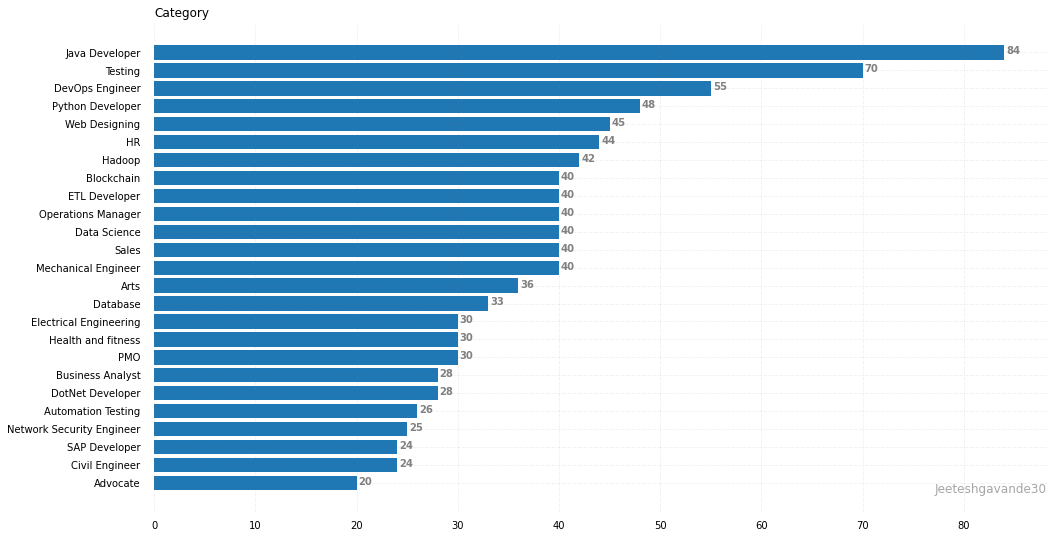

In [7]:
def barPlot():
  fig, ax = plt.subplots(figsize =(16, 9))

  # Horizontal Bar Plot
  ax.barh(x_axis,y_axis)

  for s in ['top', 'bottom', 'left', 'right']:
      ax.spines[s].set_visible(False)
  
  # Remove x, y Ticks
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')
  
  # Add padding between axes and labels
  ax.xaxis.set_tick_params(pad = 5)
  ax.yaxis.set_tick_params(pad = 10)
  
  # Add x, y gridlines
  ax.grid(b = True, color ='grey',
          linestyle ='-.', linewidth = 0.5,
          alpha = 0.2)
  
  # Show top values
  ax.invert_yaxis()
  
  # Add annotation to bars
  for i in ax.patches:
      plt.text(i.get_width()+0.2, i.get_y()+0.5,
              str(round((i.get_width()), 2)),
              fontsize = 10, fontweight ='bold',
              color ='grey')
  
  # Add Plot Title
  ax.set_title('Category',loc ='left', )
  
  # Add Text watermark
  fig.text(0.9, 0.15, 'Jeeteshgavande30', fontsize = 12,color ='grey', ha ='right', va ='bottom',alpha = 0.7)
  
  # Show Plot
  plt.show()

barPlot()

**Data Pre-processing**

In [8]:
def custom_standardization(Text):
    Text = re.sub('<br />', ' ', Text) #removing HTML
    Text = re.sub('https?://\S+|www\.\S+','', Text)#removing hyperlink
    Text = re.sub('RT|cc','', Text)# remove RT and cc
    Text = re.sub('#\S+','', Text) # remove hashtags

    Text = re.sub('\[.*?\]','', Text) #removing square brackets  
    Text = re.sub('[^\x00-\x7f]','', Text) 

    Text = re.sub( '[%s]' % re.escape(string.punctuation),'', Text) #removing puncuation
    Text = re.sub('\w*\d\w*','', Text)#remove words containing numbers
    return Text


In [9]:
data['CleanResume'] = data.Resume.apply(lambda x: custom_standardization(x))

In [10]:
data.head()

,Category,Resume,CleanResume
0,Data Science,Skills * Programming Languages: Python (pandas...,Skills Programming Languages Python pandas nu...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,Education Details \r\nMay to May BE UITRGP...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",Areas of Interest Deep Learning Control System...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,Skills R Python SAP HANA Tableau SAP HANA...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",Education Details \r\n MCA YMCAUST Faridaba...


In [11]:
X = data['CleanResume']
y = data['Category']

In [12]:
# Replacing space between charecter(e.g "Data Science" to "DataScience") 
# To get single array EX=> {Data:6},{Science:7},{HR:8}
# So we will have some array of 2D and some of 1D. That can cause the problem..
for i in range(len(y)):
  y[i] = y[i].replace(" ","")

**Split into test and train**

In [13]:
X_train, X_test, y_train,y_test = train_test_split(X,y, random_state=42, shuffle=True, test_size=0.17)

**Tokenize features and labels**

In [14]:
vocab_size = 6000
embedding_dim = 16
max_length = 6000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

**Tokenizing features -**

In [15]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok, lower=True)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

In [16]:
X_sequences = tokenizer.texts_to_sequences(X_train)
X_padded = pad_sequences(X_sequences,maxlen=max_length,padding=padding_type, truncating=trunc_type)

In [17]:
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, padding=padding_type, truncating=trunc_type)

**Tokenizing labels -**

In [18]:
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(y)
word_index = tokenizer.word_index

In [19]:
y_sequences = tokenizer.texts_to_sequences(y_train)
# y_padded = pad_sequences(y_sequences,maxlen=300,padding=padding_type, truncating=trunc_type)

In [20]:
y_testing_sequences = tokenizer.texts_to_sequences(y_test)
# y_testing_padded = pad_sequences(y_testing_sequences,maxlen=300, padding=padding_type, truncating=trunc_type)

In [21]:
y_sequences

[[3],
 [2],
 [19],
 [6],
 [5],
 [9],
 [1],
 [10],
 [3],
 [10],
 [13],
 [9],
 [2],
 [2],
 [6],
 [15],
 [9],
 [11],
 [23],
 [13],
 [11],
 [3],
 [2],
 [2],
 [4],
 [8],
 [8],
 [15],
 [2],
 [21],
 [13],
 [11],
 [16],
 [14],
 [6],
 [7],
 [10],
 [6],
 [17],
 [2],
 [11],
 [1],
 [18],
 [1],
 [8],
 [25],
 [1],
 [3],
 [20],
 [9],
 [8],
 [6],
 [16],
 [20],
 [1],
 [19],
 [25],
 [4],
 [9],
 [15],
 [3],
 [2],
 [13],
 [2],
 [20],
 [8],
 [25],
 [8],
 [20],
 [16],
 [1],
 [3],
 [20],
 [13],
 [14],
 [1],
 [7],
 [23],
 [8],
 [6],
 [17],
 [1],
 [3],
 [24],
 [9],
 [19],
 [6],
 [3],
 [24],
 [4],
 [23],
 [20],
 [10],
 [7],
 [9],
 [18],
 [1],
 [19],
 [10],
 [12],
 [2],
 [7],
 [21],
 [1],
 [1],
 [19],
 [22],
 [1],
 [8],
 [5],
 [2],
 [1],
 [13],
 [1],
 [2],
 [11],
 [11],
 [4],
 [2],
 [7],
 [12],
 [4],
 [17],
 [2],
 [19],
 [10],
 [1],
 [2],
 [9],
 [6],
 [5],
 [22],
 [4],
 [23],
 [3],
 [23],
 [14],
 [11],
 [4],
 [17],
 [8],
 [22],
 [11],
 [23],
 [2],
 [24],
 [3],
 [5],
 [14],
 [1],
 [7],
 [13],
 [25],
 [2],
 [5],
 

**Building the model**

In [22]:
embedding_dim = 64
# input vocab of size 6000, and output embedding dimension of size 64 

model = Sequential([
  Embedding(vocab_size, embedding_dim,),
  Bidirectional(LSTM(64)),
  Dense(64, activation='relu'),
  Dense(26, activation='softmax')# 26 lables are there....
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          384000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 26)                1690      
                                                                 
Total params: 459,994
Trainable params: 459,994
Non-trainable params: 0
_________________________________________________________________


In [23]:
# loss = tf.keras.losses.sparse_categorical_crossentropy(from_logits=False)
# loss = tf.keras.losses.categorical_crossentropy(from_logits=True)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

y_padded = np.array(y_sequences)
y_testing_padded = np.array(y_testing_sequences)

In [24]:
earlyStopping = EarlyStopping(monitor='val_accuracy',patience=1)

history = model.fit(X_padded,y_padded,epochs = 10, validation_data=(testing_padded,y_testing_padded ), callbacks=[earlyStopping])

Epoch 1/10
25/25 [==============================] - 22s 743ms/step - loss: 3.2148 - accuracy: 0.0852 - val_loss: 3.1628 - val_accuracy: 0.0854
Epoch 2/10
25/25 [==============================] - 9s 348ms/step - loss: 2.9629 - accuracy: 0.1341 - val_loss: 2.7566 - val_accuracy: 0.2561
Epoch 3/10
25/25 [==============================] - 9s 344ms/step - loss: 2.4422 - accuracy: 0.2469 - val_loss: 2.2903 - val_accuracy: 0.3171
Epoch 4/10
25/25 [==============================] - 8s 341ms/step - loss: 1.9592 - accuracy: 0.4286 - val_loss: 1.7926 - val_accuracy: 0.4939
Epoch 5/10
25/25 [==============================] - 9s 342ms/step - loss: 1.4788 - accuracy: 0.6341 - val_loss: 1.3859 - val_accuracy: 0.6037
Epoch 6/10
25/25 [==============================] - 9s 342ms/step - loss: 1.0666 - accuracy: 0.7682 - val_loss: 0.9693 - val_accuracy: 0.7073
Epoch 7/10
25/25 [==============================] - 9s 342ms/step - loss: 0.7225 - accuracy: 0.8534 - val_loss: 0.6809 - val_accuracy: 0.8293
Epoch

**evaluating**

In [25]:
score = model.evaluate(testing_padded, y_testing_padded, verbose=1)

6/6 [==============================] - 1s 148ms/step - loss: 0.3018 - accuracy: 0.9512


In [26]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3017657995223999
Test Accuracy: 0.9512194991111755


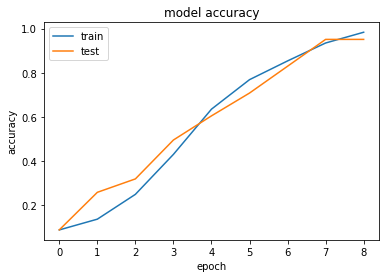

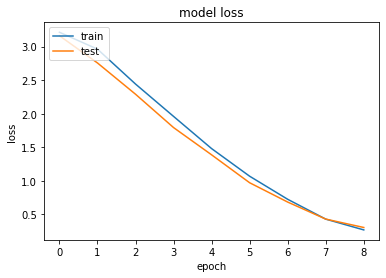

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()